In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D,Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import numpy as np
from sklearn.metrics import accuracy_score
import pathlib
from tensorflow.keras.optimizers import RMSprop

In [2]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)
    
def create_checkpoint_callback(model_name):
  return tf.keras.callbacks.ModelCheckpoint(filepath=f"{model_name}/checkpoint.ckpt",
                                                          #  monitor="val_accuracy",
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           save_freq="epoch")

es_cb = EarlyStopping(monitor='val_loss', patience=10)

In [9]:
data=pd.read_csv('Electric_Production.csv',parse_dates=["DATE"],index_col=["DATE"])
data

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


<AxesSubplot:xlabel='DATE'>

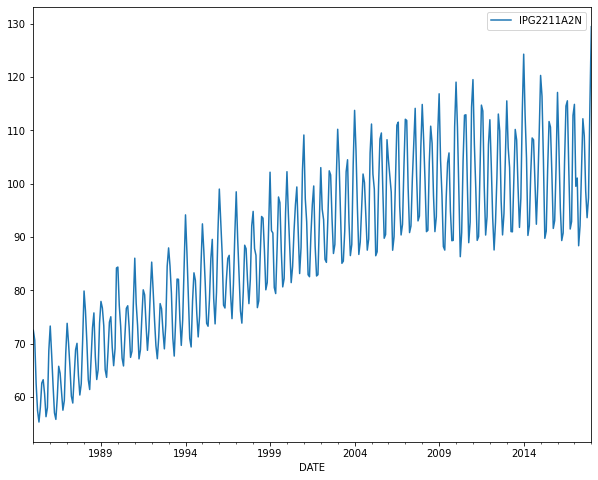

In [10]:
data.plot(figsize=(10,8))

In [11]:
dates = data.index.to_numpy()
rate = data["IPG2211A2N"].to_numpy()

In [13]:
split_time = int(0.8 * len(dates))
time_train = dates[:split_time]
x_train = rate[:split_time]
time_valid = dates[split_time:]
x_valid = rate[split_time:]

window_size = 7
batch_size = 32
shuffle_buffer_size = 1000

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [15]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [25]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [20]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
test_set=windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model_15 = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=64, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Dense(1),
],name='model_15')

optimizer = tf.keras.optimizers.Adam()
model_15.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model_15.fit(train_set, epochs=300,validation_data=test_set,
            callbacks=[create_checkpoint_callback(model_name=model_15.name),es_cb])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(317,)
Epoch 1/300
10/10 [==============================] - 0s 19ms/step - loss: 70.4181 - mae: 70.9181 - val_loss: 73.3499 - val_mae: 73.8499
Epoch 2/300
10/10 [==============================] - 0s 9ms/step - loss: 54.2687 - mae: 54.7687 - val_loss: 53.9475 - val_mae: 54.4475
Epoch 3/300
10/10 [==============================] - 0s 12ms/step - loss: 37.7004 - mae: 38.2004 - val_loss: 33.3028 - val_mae: 33.8028
Epoch 4/300
10/10 [==============================] - 0s 10ms/step - loss: 21.8006 - mae: 22.2955 - val_loss: 21.8989 - val_mae: 22.3953
Epoch 5/300
10/10 [==============================] - 0s 9ms/step - loss: 17.7945 - mae: 18.2839 - val_loss: 21.3479 - val_mae: 21.8387
Epoch 6/300
10/10 [==============================] - 0s 9ms/step - loss: 16.1176 - mae: 16.6105 - val_loss: 18.0770 - val_mae: 18.5747
Epoch 7/300
10/10 [=

10/10 [==============================] - 0s 10ms/step - loss: 4.3023 - mae: 4.7812 - val_loss: 5.6667 - val_mae: 6.1477
Epoch 62/300
10/10 [==============================] - 0s 9ms/step - loss: 4.2861 - mae: 4.7644 - val_loss: 5.6290 - val_mae: 6.1047
Epoch 63/300
10/10 [==============================] - 0s 8ms/step - loss: 4.2621 - mae: 4.7392 - val_loss: 5.6061 - val_mae: 6.0823
Epoch 64/300
10/10 [==============================] - 0s 9ms/step - loss: 4.2421 - mae: 4.7185 - val_loss: 5.5837 - val_mae: 6.0614
Epoch 65/300
10/10 [==============================] - 0s 9ms/step - loss: 4.2366 - mae: 4.7097 - val_loss: 5.5656 - val_mae: 6.0440
Epoch 66/300
10/10 [==============================] - 0s 7ms/step - loss: 4.2247 - mae: 4.6997 - val_loss: 5.7167 - val_mae: 6.1965
Epoch 67/300
10/10 [==============================] - 0s 5ms/step - loss: 4.2386 - mae: 4.7162 - val_loss: 5.6044 - val_mae: 6.0834
Epoch 68/300
10/10 [==============================] - 0s 9ms/step - loss: 4.1844 - mae: 

Epoch 123/300
10/10 [==============================] - 0s 9ms/step - loss: 3.7392 - mae: 4.2144 - val_loss: 4.9590 - val_mae: 5.4325
Epoch 124/300
10/10 [==============================] - 0s 7ms/step - loss: 3.7193 - mae: 4.1935 - val_loss: 5.1282 - val_mae: 5.6112
Epoch 125/300
10/10 [==============================] - 0s 6ms/step - loss: 3.7957 - mae: 4.2694 - val_loss: 5.1766 - val_mae: 5.6596
Epoch 126/300
10/10 [==============================] - 0s 11ms/step - loss: 3.7871 - mae: 4.2624 - val_loss: 4.9407 - val_mae: 5.4163
Epoch 127/300
10/10 [==============================] - 0s 7ms/step - loss: 3.7413 - mae: 4.2164 - val_loss: 4.9430 - val_mae: 5.4167
Epoch 128/300
10/10 [==============================] - 0s 7ms/step - loss: 3.7396 - mae: 4.2132 - val_loss: 4.9982 - val_mae: 5.4744
Epoch 129/300
10/10 [==============================] - 0s 8ms/step - loss: 3.7211 - mae: 4.1965 - val_loss: 4.9576 - val_mae: 5.4357
Epoch 130/300
10/10 [==============================] - 0s 10ms/step 

10/10 [==============================] - 0s 6ms/step - loss: 3.6059 - mae: 4.0772 - val_loss: 4.8691 - val_mae: 5.3473
Epoch 185/300
10/10 [==============================] - 0s 10ms/step - loss: 3.5958 - mae: 4.0705 - val_loss: 4.7769 - val_mae: 5.2547
Epoch 186/300
10/10 [==============================] - 0s 6ms/step - loss: 3.5885 - mae: 4.0611 - val_loss: 4.7836 - val_mae: 5.2595
Epoch 187/300
10/10 [==============================] - 0s 6ms/step - loss: 3.6071 - mae: 4.0812 - val_loss: 4.7773 - val_mae: 5.2513
Epoch 188/300
10/10 [==============================] - 0s 7ms/step - loss: 3.5886 - mae: 4.0604 - val_loss: 4.7877 - val_mae: 5.2651
Epoch 189/300
10/10 [==============================] - 0s 6ms/step - loss: 3.6054 - mae: 4.0780 - val_loss: 4.8219 - val_mae: 5.2928
Epoch 190/300
10/10 [==============================] - 0s 12ms/step - loss: 3.6293 - mae: 4.1028 - val_loss: 4.7733 - val_mae: 5.2470
Epoch 191/300
10/10 [==============================] - 0s 9ms/step - loss: 3.6261

10/10 [==============================] - 0s 6ms/step - loss: 3.5129 - mae: 3.9867 - val_loss: 4.7258 - val_mae: 5.2040
Epoch 246/300
10/10 [==============================] - 0s 6ms/step - loss: 3.5194 - mae: 3.9885 - val_loss: 4.7525 - val_mae: 5.2299
Epoch 247/300
10/10 [==============================] - 0s 5ms/step - loss: 3.5059 - mae: 3.9784 - val_loss: 4.8052 - val_mae: 5.2845
Epoch 248/300
10/10 [==============================] - 0s 6ms/step - loss: 3.5462 - mae: 4.0178 - val_loss: 4.7379 - val_mae: 5.2188
Epoch 249/300
10/10 [==============================] - 0s 6ms/step - loss: 3.5092 - mae: 3.9822 - val_loss: 4.6864 - val_mae: 5.1611
Epoch 250/300
10/10 [==============================] - 0s 6ms/step - loss: 3.4988 - mae: 3.9719 - val_loss: 4.7258 - val_mae: 5.2027
Epoch 251/300
10/10 [==============================] - 0s 10ms/step - loss: 3.5179 - mae: 3.9905 - val_loss: 4.6694 - val_mae: 5.1419
Epoch 252/300
10/10 [==============================] - 0s 6ms/step - loss: 3.5059 

In [21]:
min(history.history['val_loss'])

4.669438362121582

In [23]:
rnn_forecast = model_forecast(model_15, rate[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

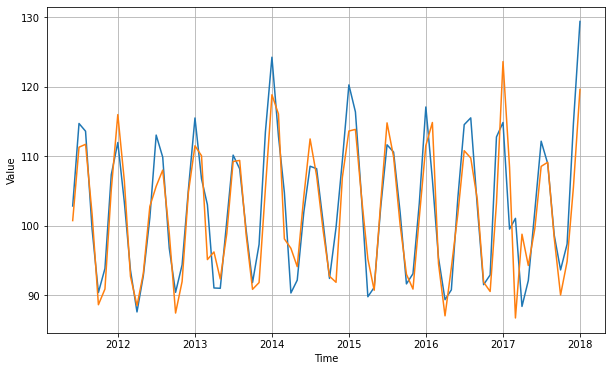

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,format='-')
plot_series(time_valid, rnn_forecast,format='-')

In [28]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
test_set=windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model_16 = tf.keras.models.Sequential([
  tf.keras.layers.Dense(128,activation="relu"),
  tf.keras.layers.Dense(1,activation="linear"),
],name='model_16')

optimizer = tf.keras.optimizers.Adam()
model_16.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model_16.fit(train_set, epochs=100,validation_data=test_set,
            callbacks=[create_checkpoint_callback(model_name=model_16.name)])

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(317,)
Epoch 1/100
10/10 [==============================] - 1s 20ms/step - loss: 78.3870 - mae: 78.8870 - val_loss: 86.0362 - val_mae: 86.5362
Epoch 2/100
10/10 [==============================] - 0s 11ms/step - loss: 66.8454 - mae: 67.3454 - val_loss: 72.2078 - val_mae: 72.7078
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 55.2121 - mae: 55.7121 - val_loss: 58.2417 - val_mae: 58.7417
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 43.3951 - mae: 43.8951 - val_loss: 43.7042 - val_mae: 44.2042
Epoch 5/100
10/10 [==============================] - 0s 11ms/step - loss: 30.9761 - mae: 31.4761 - val_loss: 28.4073 - val_mae: 28.9073
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 17.8238 - mae: 18.3236 - val_loss: 12.2899 - val_mae: 12.7809
Epoch 7/100
10/10 

10/10 [==============================] - 0s 11ms/step - loss: 5.6353 - mae: 6.1224 - val_loss: 7.6157 - val_mae: 8.1052
Epoch 62/100
10/10 [==============================] - 0s 8ms/step - loss: 5.6286 - mae: 6.1141 - val_loss: 7.6342 - val_mae: 8.1267
Epoch 63/100
10/10 [==============================] - 0s 7ms/step - loss: 5.6293 - mae: 6.1156 - val_loss: 7.6200 - val_mae: 8.1103
Epoch 64/100
10/10 [==============================] - 0s 6ms/step - loss: 5.6270 - mae: 6.1137 - val_loss: 7.6188 - val_mae: 8.1091
Epoch 65/100
10/10 [==============================] - 0s 6ms/step - loss: 5.6263 - mae: 6.1123 - val_loss: 7.6253 - val_mae: 8.1149
Epoch 66/100
10/10 [==============================] - 0s 7ms/step - loss: 5.6262 - mae: 6.1123 - val_loss: 7.6225 - val_mae: 8.1125
Epoch 67/100
10/10 [==============================] - 0s 6ms/step - loss: 5.6273 - mae: 6.1132 - val_loss: 7.6208 - val_mae: 8.1109
Epoch 68/100
10/10 [==============================] - 0s 10ms/step - loss: 5.6258 - mae:

In [29]:
min(history.history['val_loss'])

7.599806785583496

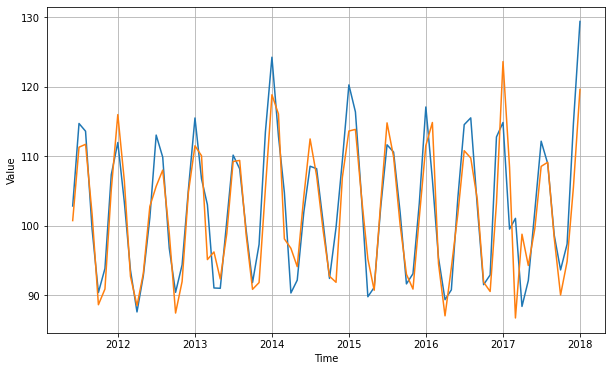

In [30]:
rnn_forecast = model_forecast(model_15, rate[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid,format='-')
plot_series(time_valid, rnn_forecast,format='-')